# Многомерный регрессионный анализ влияния различных факторов на продажи

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.api import het_breuschpagan, durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 1.941e+04
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        00:09:25   Log-Likelihood:                -14571.
No. Observations:                2000   AIC:                         2.915e+04
Df Residuals:                    1995   BIC:                         2.918e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -702.7355 

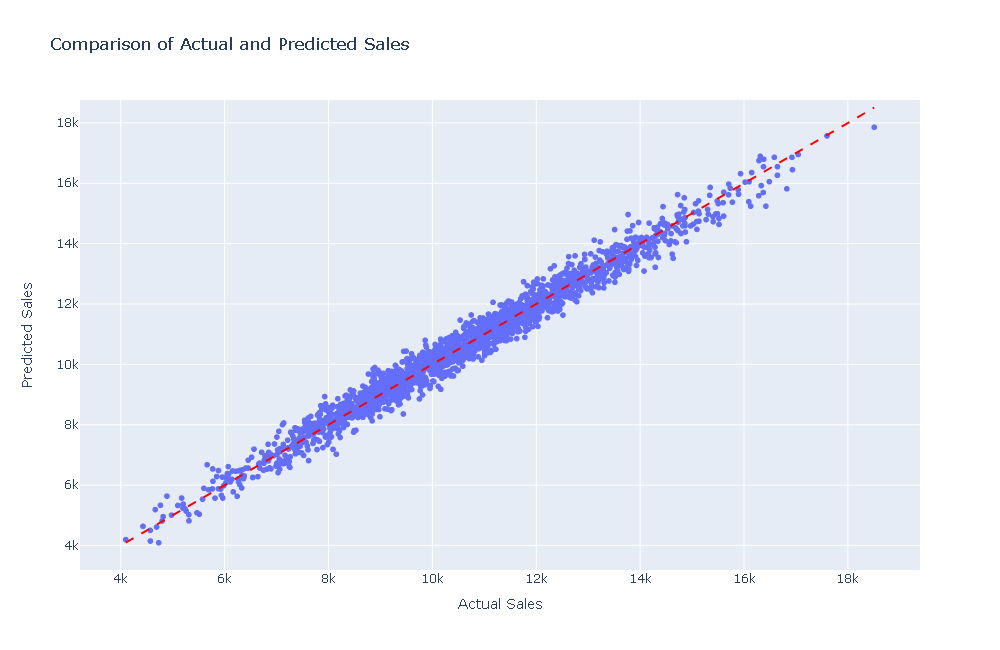

MSE: 124668.98
R^2: 0.97


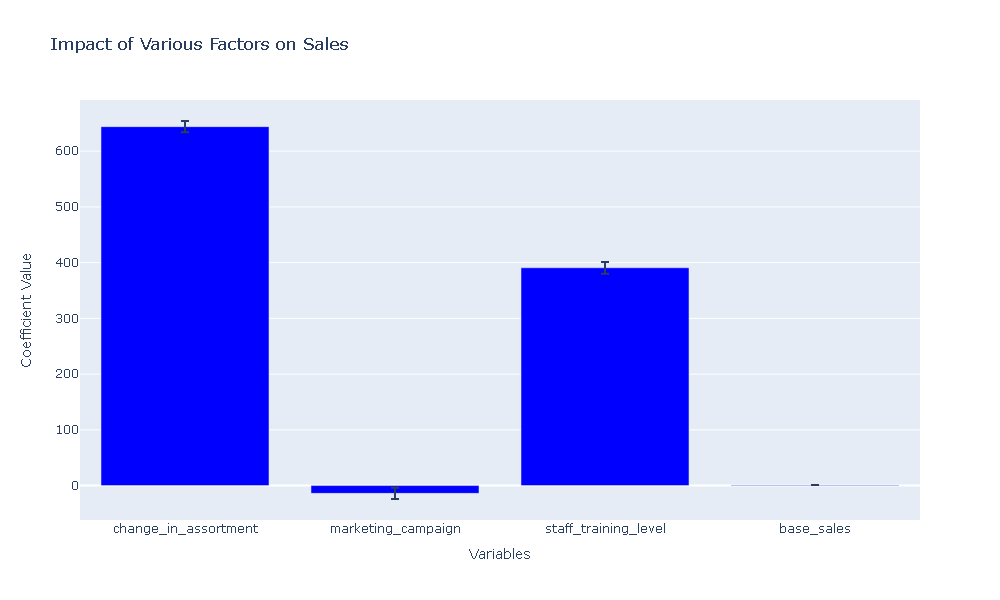

In [2]:
np.random.seed(42)

# Создание симулированных данных
num_stores = 2000
data = pd.DataFrame({
    'store_id': np.arange(num_stores),
    'change_in_assortment': np.random.choice(['none', 'minor', 'major'], num_stores, p=[0.5, 0.3, 0.2]),
    'marketing_campaign': np.random.choice(['no', 'standard', 'intensive'], num_stores, p=[0.5, 0.3, 0.2]),
    'staff_training_level': np.random.choice(['none', 'basic', 'advanced'], num_stores, p=[0.4, 0.4, 0.2]),
    'base_sales': np.random.normal(10000, 2000, num_stores)  # базовый уровень продаж
})

# Кодирование категориальных переменных
mapping = {
    'change_in_assortment': {'none': 0, 'minor': 1, 'major': 2},
    'marketing_campaign': {'no': 0, 'standard': 1, 'intensive': 2},
    'staff_training_level': {'none': 0, 'basic': 1, 'advanced': 2}
}
for var, map_dict in mapping.items():
    data[var] = data[var].map(map_dict)

# Симуляция взаимодействий и нелинейностей в продажах
effect_noise = np.random.normal(0, 300, num_stores)
interaction = (data['change_in_assortment'] * data['marketing_campaign'] * 200)
data['sales'] = data['base_sales'] * (1 + 0.05 * data['change_in_assortment'] - 0.008 * data['marketing_campaign']**2 + \
                                      0.04 * data['staff_training_level']) + effect_noise + interaction

# Подготовка данных для OLS
X = data[['change_in_assortment', 'marketing_campaign', 'staff_training_level','base_sales']]
X = sm.add_constant(X)  # Добавление константы для перехвата
y = data['sales']

# Создание и обучение модели OLS
model = sm.OLS(y, X).fit()

# Получение предсказаний от модели
predictions = model.predict(X)

# Вывод результатов модели
print(model.summary())

fig = px.scatter(
    x=y, 
    y=predictions, 
    labels={'x': 'Actual Sales', 'y': 'Predicted Sales'},
    title='Comparison of Actual and Predicted Sales'
)

# Добавление линии идеального соответствия
fig.add_shape(
    type='line', 
    x0=y.min(), y0=y.min(), 
    x1=y.max(), y1=y.max(),
    line=dict(color='Red', dash='dash')
)

fig.update_layout(
    width=1000,  # ширина в пикселях
    height=650  # высота в пикселях
)

# Показать график
fig.show("png")



# Расчет и вывод метрик качества
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')

# Визуализация коэффициентов модели
coefficients = model.params[1:]  # Исключаем константу
coeff_names = coefficients.index
errors = model.bse[1:]  # Стандартные ошибки для коэффициентов, исключая константу
p_values = model.pvalues[1:]  # p-значения, исключая константу
conf_intervals = model.conf_int().iloc[1:]  # Доверительные интервалы, исключая константу

# Создание бар-графика с Plotly
fig = go.Figure()

fig.add_trace(go.Bar(
    x=coeff_names,
    y=coefficients,
    name='Coefficient Value',
    error_y=dict(type='data', array=errors),
    marker_color='blue'
))

# Добавление информации о p-значениях и доверительных интервалах в подсказки
fig.update_traces(
    hovertemplate="<b>%{x}</b><br>Value: %{y:.3f}<br>Std Error: %{error_y.array:.3f}<br>P-value: %{customdata[0]:.3f}<br>CI Lower: %{customdata[1]:.3f}<br>CI Upper: %{customdata[2]:.3f}",
    customdata=list(zip(p_values, conf_intervals[0], conf_intervals[1]))
)

fig.update_layout(
    title='Impact of Various Factors on Sales',
    xaxis_title='Variables',
    yaxis_title='Coefficient Value',
    hovermode='closest',
    width=1000,  # ширина в пикселях
    height=600  # высота в пикселях
)

fig.show("png")
